In [5]:
# Importing Relevant Libraries
import numpy as np
import math
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import *
from pyspark.sql.types import *
from pyspark.ml.linalg import *
from pyspark.sql.functions import *
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import PipelineModel
from pyspark.ml.stat import Correlation
import seaborn as sns
import pickle
import os
import matplotlib.pyplot as plt

In [6]:
# File location and type
file_location = "./lish-moa/train_features.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
features_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [7]:
# File location and type
file_location = "./lish-moa/train_targets_scored.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
targets_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

### An interesting pattern in the gene expressions and cell viability values

In [8]:
features_df = features_data.toPandas()

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


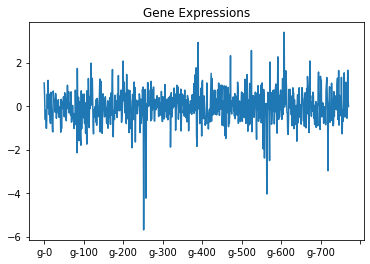

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


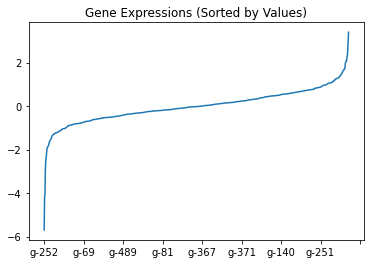

In [9]:
# Checking progression of gene_expressions values

# gene_expression values for 1st sample
features_df.iloc[0, 4:4+772].plot()
plt.title('Gene Expressions')
plt.show()

# Sorted gene_feature values for 1st sample
features_df.iloc[0, 4:4+772].sort_values().plot()
plt.title('Gene Expressions (Sorted by Values)')
plt.show()

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


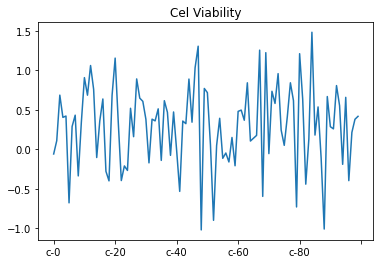

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


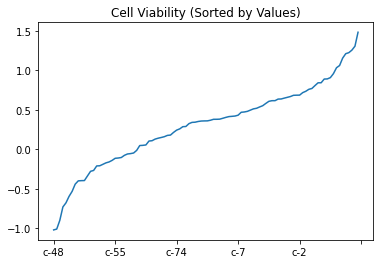

In [10]:
# Checking progression of cell viability values

# cell viability values for 1st sample
features_df.iloc[0, 4+772:].plot()
plt.title('Cel Viability')
plt.show()

# Sorted gene_feature values for 1st sample
features_df.iloc[0, 4+772:].sort_values().plot()
plt.title('Cell Viability (Sorted by Values)')
plt.show()

As can be seen from the above graphs, gene expression and cell viability data (when sorted by values) might be interpreted as some time series data (same pattern exists for all samples). This info is further used in feature selection part, wherein max and min values of gene expression and cell viability are added as features for every sample 

### Pre-Processing

In [5]:
# Dropping samples with cp_type = 'ctl_vehicle' (placebo group would have no activations in any MoAs) 
features_and_targets = features_data.join(targets_data, features_data.sig_id == targets_data.sig_id, how='inner').drop(targets_data.sig_id)
features_and_targets = features_and_targets.filter("cp_type = 'trt_cp'")

In [6]:
# One hot encoding cp_dose

# Indexing different categories in cp_type and storing in column 'cp_type_index'
string_indexer = StringIndexer(inputCol = 'cp_dose', outputCol = 'cp_dose_index')
features_and_targets = string_indexer.fit(features_and_targets).transform(features_and_targets).drop('cp_dose')

# One hot encoded and stored in cp_type_vector column
encoder = OneHotEncoder(inputCols=['cp_dose_index'],
                        outputCols=['cp_dose'], dropLast = False)

features_and_targets = encoder.fit(features_and_targets).transform(features_and_targets).drop('cp_dose_index')

In [7]:
# Label Encoding cp_time
assembler = VectorAssembler(inputCols = ['cp_time'], outputCol = 'cp_time_vector')
features_and_targets = assembler.transform(features_and_targets).drop('cp_time')

mm_scaler = MinMaxScaler(inputCol = 'cp_time_vector', outputCol = 'cp_time_scaled_vector', min = 0, max = 2)
features_and_targets = mm_scaler.fit(features_and_targets).transform(features_and_targets).drop('cp_time_vector')

firstElement=udf(lambda v:float(v[0]),FloatType())
features_and_targets = features_and_targets.withColumn('cp_time', firstElement(features_and_targets['cp_time_scaled_vector'])).drop('cp_time_scaled_vector')

### Stratified train-test split

In [8]:
'''
As our dataset is imbalanced, stratified train-test split was done so that test score is relevant. To perform stratified
split, I encoded all possible columns of target labels and then stratified was split was done based on the encoded value.
This ensures that, for every combination of target labels in the dataset, there are some samples both in train and test set
'''

# Encoding target labels' combination
def vector_to_string(a):
  s=''
  for i in a:
    s = s + str(i) + ' '
  s.strip()
  return s
    
  
vector_to_string = udf(vector_to_string)   
spark.udf.register("vector_to_string", vector_to_string)

# Target columns names
target_names = []
for feature in targets_data.columns:
  if feature != 'sig_id':
    target_names.append(feature)
    
temp_df = features_and_targets.withColumn('target_vector', (vector_to_string(array([features_and_targets[col] for col in target_names])))).select(['sig_id', 'target_vector'])
string_indexer = StringIndexer(inputCol = 'target_vector', outputCol = 'target')
string_indexer_model = string_indexer.fit(temp_df)
temp_df = string_indexer_model.transform(temp_df).drop('target_vector')

data = features_and_targets.join(temp_df, features_and_targets.sig_id == temp_df.sig_id, how = 'inner').drop(temp_df.sig_id)

unique_targets = data.select('target').distinct().collect()

# Train-test split (80-20 split)
fraction = {}
split_ratio = 0.2
for row in unique_targets:
  fraction[row.target] = split_ratio
  
test_data = data.sampleBy('target', fractions=fraction, seed = 0)
data.createOrReplaceTempView('data_table')
test_data.createOrReplaceTempView('test_data_table')
train_data = spark.sql('select * from data_table as t1 where t1.sig_id not in (select t2.sig_id from test_data_table as t2)') 

# Asserting no data leakage
train_data.createOrReplaceTempView('train_data_table')
count = spark.sql('select * from train_data_table as t1 where t1.sig_id in (select t2.sig_id from test_data_table as t2)').count()
assert count == 0

train_data = train_data.drop('target')
test_data = test_data.drop('target')

In [9]:
gene_feature_names = [] # list containing gene expression names
cell_feature_names = [] # list containing cell viability names

for i in range(772):
  gene_feature_names.append('g-' + str(i))

for i in range(100):
  cell_feature_names.append('c-' + str(i))

other_feature_names = ['sig_id', 'cp_type', 'cp_time', 'cp_dose']

target_names = [col for col in train_data.columns if col not in gene_feature_names + cell_feature_names + other_feature_names]

### Feature Engineering

In [ ]:
# Engineering new features: max and min values for gene expression and cell viability data


max_gene_train_df = train_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_train_df = train_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_train_df = train_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_train_df = train_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

max_gene_test_df = test_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_test_df = test_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_test_df = test_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_test_df = test_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

### Feature Selection

In [10]:
# Finding Correlation among cont. gene expression and cell viability data to remove all redundant features

# Correlation among gene expressions and cell viability

cont_features = gene_feature_names + cell_feature_names
cont_features_df = train_data.select(cont_features)

va = VectorAssembler(inputCols = cont_features, outputCol = 'features')
cont_features_df = va.transform(cont_features_df)

corr_df = Correlation.corr(cont_features_df, 'features', 'pearson').collect()[0][0]

corr_mat = corr_df.toArray()


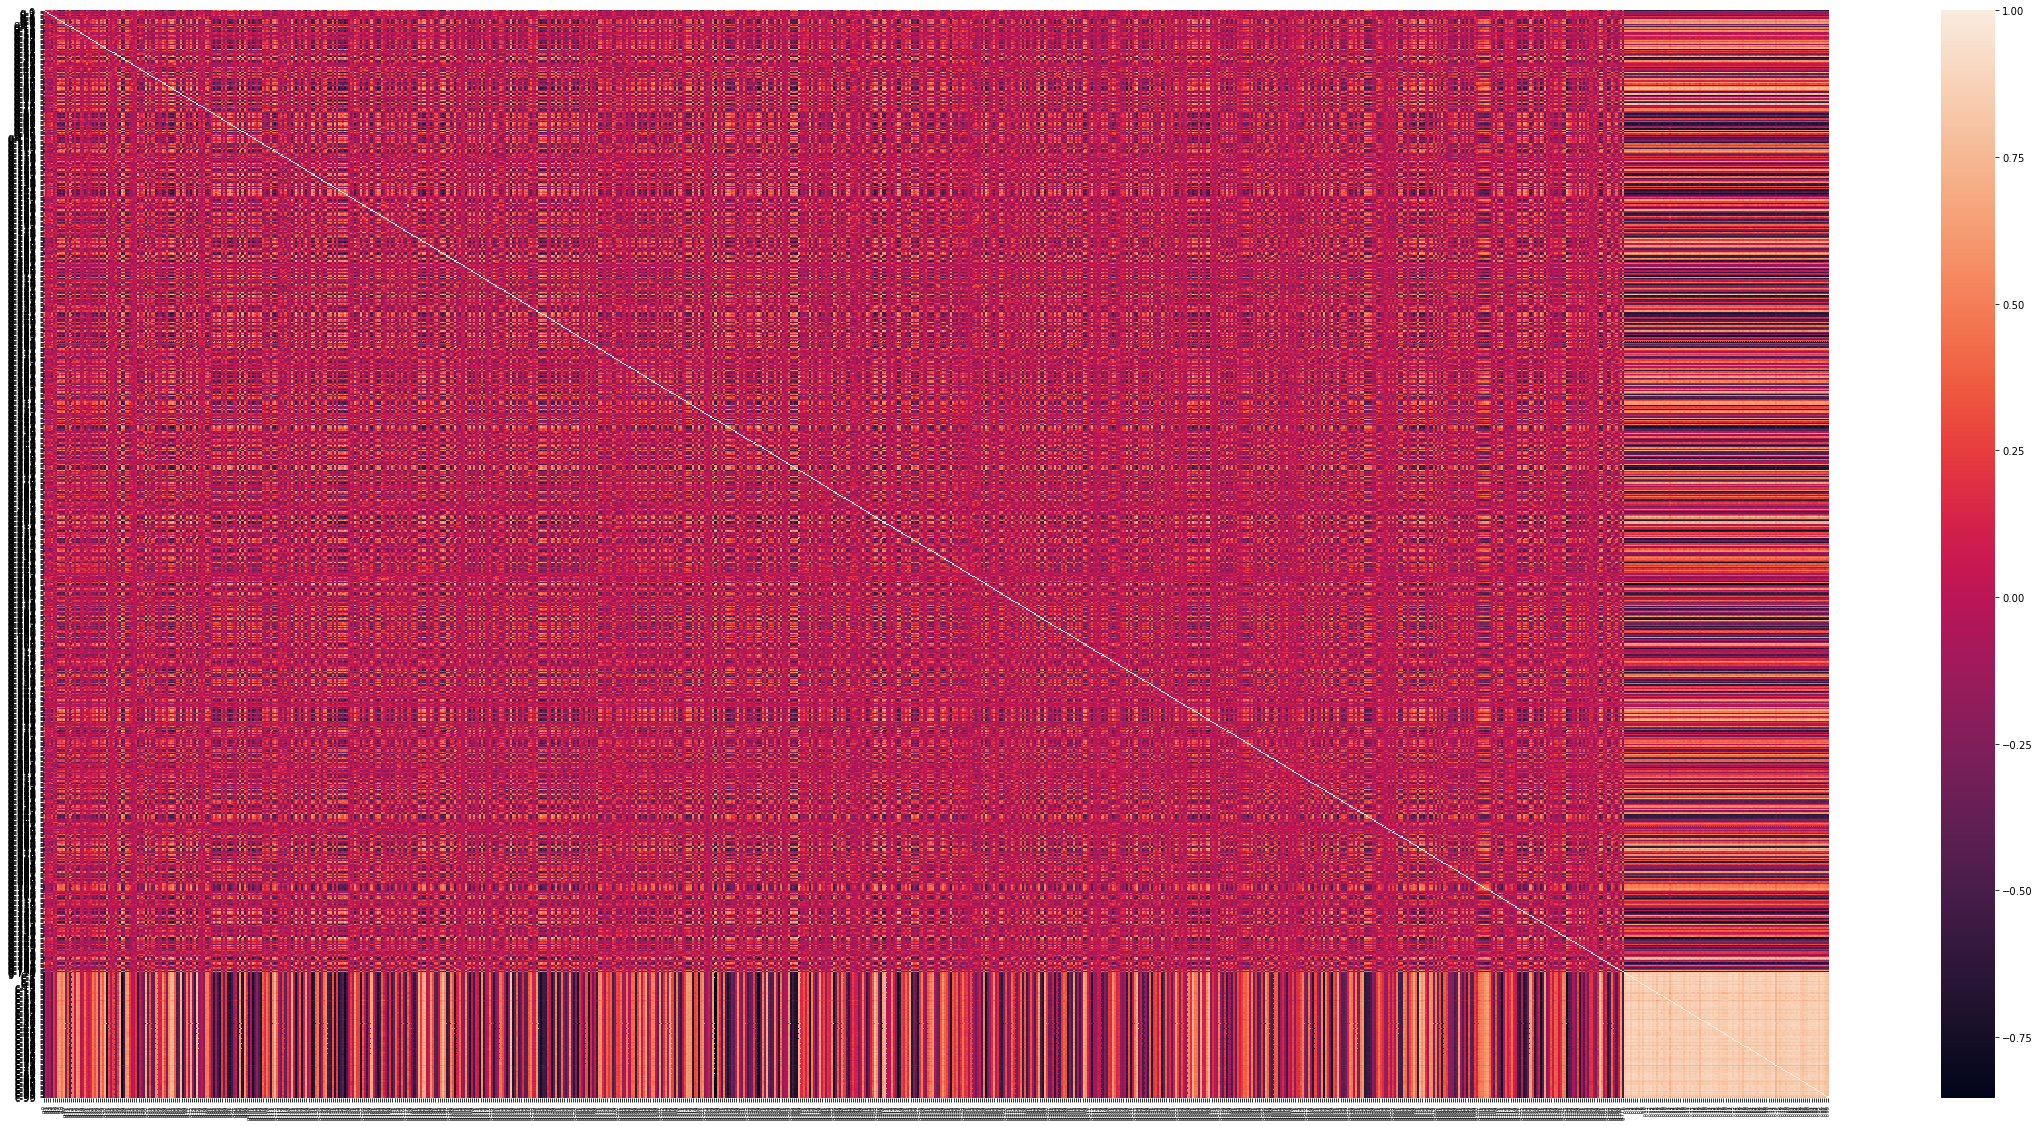

In [11]:
plt.figure(figsize=(40,20))
sns.heatmap(corr_mat, xticklabels = gene_feature_names + cell_feature_names, yticklabels=gene_feature_names + cell_feature_names)
plt.xticks(rotation = 90, fontsize = 5)
plt.show()

In [12]:
# Feature Selection: Removing highly correlated continuos features
threshold = 0.6 
columns = np.full((corr_mat.shape[0], ), True, dtype = bool)
for i in range(corr_mat.shape[0]):
  for j in range(i+1, corr_mat.shape[0]):
    if not columns[j]:
      continue
    if corr_mat[i,j] >= threshold or corr_mat[i,j] <= -threshold :
      if columns[j]:
        columns[j] = False

selected_features = [(gene_feature_names + cell_feature_names)[i] for i, j in enumerate(columns) if j==True]

In [13]:
len(selected_features) # Number of features left after removing correlated  features

530

### Standardizing selected features

Adding engineered  features and then standardizing all continuous features

In [14]:
train_data = train_data.select(other_feature_names + selected_features + target_names).join(max_gene_train_df, on = 'sig_id', how = 'inner').join(min_gene_train_df, on = 'sig_id', how = 'inner').join(max_cell_train_df, on = 'sig_id', how = 'inner').join(min_cell_train_df, on = 'sig_id', how = 'inner')
test_data = test_data.select(other_feature_names + selected_features + target_names).join(max_gene_test_df, on = 'sig_id', how = 'inner').join(min_gene_test_df, on = 'sig_id', how = 'inner').join(max_cell_test_df, on = 'sig_id', how = 'inner').join(min_cell_test_df, on = 'sig_id', how = 'inner')

In [ ]:
selected_features = selected_features + ['gene_max', 'gene_min', 'cell_max', 'cell_min']

In [15]:
va = VectorAssembler(inputCols = selected_features, outputCol = 'feature_vector')

train_data = va.transform(train_data)
test_data = va.transform(test_data)

ss = StandardScaler(withMean=True, inputCol = 'feature_vector', outputCol='features')
ss_model = ss.fit(train_data)

train_data = ss_model.transform(train_data).drop('feature_vector')
test_data = ss_model.transform(test_data).drop('feature_vector')

### Dimensionality Reduction (PCA)

In [16]:
k = 100 
pca = PCA(k = k, inputCol='features', outputCol='pca_features')
pca_model = pca.fit(train_data)

In [17]:
cum_var = np.cumsum(pca_model.explainedVariance.toArray())

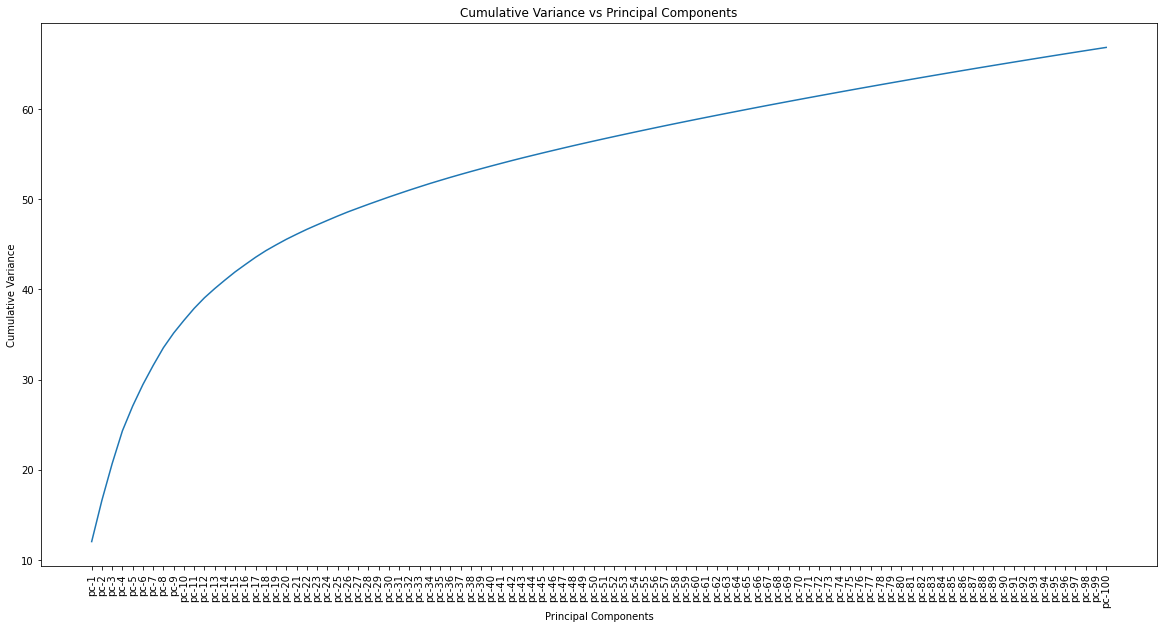

In [18]:
xlabels = ['pc-' + str(i+1) for i in range(k)]
plt.figure(figsize=(20,10))
plt.plot(xlabels, cum_var*100)
plt.xticks(rotation = 90)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance vs Principal Components')
plt.show()

In [19]:
train_data = pca_model.transform(train_data).drop('features')
test_data = pca_model.transform(test_data).drop('features')

In [20]:
train_data = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names)
test_data = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names)

### Traininig and Testing

In [21]:
def logloss(predictedProb, trueLabel):
    loss = (-trueLabel*np.log(predictedProb + 10e-15) - (1-trueLabel)*(np.log(1-predictedProb))).mean()
    return loss

In [22]:
loss = 0
losses = [] # List to store log loss error for individual target labels
untrained_labels = [] # List to store target labels for which model was not trained

for i, label in enumerate(target_names):
  
  X_train = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label])
  X_test = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label])
  one_count_train = X_train.filter(X_train[label] == 1).count()
  zero_count_train = X_train.filter(X_train[label] == 0).count()
  
#   If there are no activations for the label in the training dataset, no need to train the model (prediction would be all 0's)  
  if one_count_train == 0:
    untrained_labels.append(label)
    n = X_test.count()
    prob = np.array([0]*n)
    label = np.array(X_test.select(label).toPandas())[:,0]
    l = logloss(prob, label)
    print('No need to train the model. Will always output 0 for this label')
    
# Handling Data Imbalance: if number of samples with label 0 is more than twice the samples with label 1 - undersample
# majority class samples by half and oversample minority class samples so that counts are same 
  else:  
    factor = zero_count_train/one_count_train
    if factor>=2:
      zero_samples = X_train.filter(X_train[label]==0).sample(fraction = 0.5, withReplacement = False,  seed = 0) 
      one_samples = spark.createDataFrame(X_train.filter(X_train[label]==1).toPandas().sample(n = int(X_train.filter(X_train[label]==0).count()/2), replace = True,  random_state = 0))
      X_train = zero_samples.union(one_samples).orderBy(rand())
    
    va = VectorAssembler(inputCols = ['cp_time', 'cp_dose', 'pca_features'], outputCol = 'features')
    X_train = va.transform(X_train)
    X_test = va.transform(X_test)

    gbt = GBTClassifier(labelCol = label)
    print('Training GBT')
    gbtModel = gbt.fit(X_train)
    print('GBT Trained')
    pred_df = gbtModel.transform(X_test)
    evaluator = MulticlassClassificationEvaluator(labelCol=label, metricName='logLoss')
    l= evaluator.evaluate(pred_df)
    
  losses.append(l)
  print(f'Label Loss for {i}: {label} = {l}')
  loss+=l
  print(f'Hamming Loss after {i}: {label} = {loss/(i+1)}')
  d = {'losses': losses, 'untrained_labels': untrained_labels }
  f = open('data1.pkl', 'wb')
  pickle.dump(d, f)
  f.close()  
  print('################################')
  X_train.unpersist()
  X_test.unpersist()
  pred_df.unpersist()  

Training GBT
GBT Trained
Label Loss for 0: 5-alpha_reductase_inhibitor = 0.06285228093039079
Hamming Loss after 0: 5-alpha_reductase_inhibitor = 0.06285228093039079
################################
Training GBT
GBT Trained
Label Loss for 1: 11-beta-hsd1_inhibitor = 0.06284596826868699
Hamming Loss after 1: 11-beta-hsd1_inhibitor = 0.0628491245995389
################################
Training GBT
GBT Trained
Label Loss for 2: acat_inhibitor = 0.0764743791804708
Hamming Loss after 2: acat_inhibitor = 0.06739087612651619
################################
Training GBT
GBT Trained
Label Loss for 3: acetylcholine_receptor_agonist = 0.23010960864537292
Hamming Loss after 3: acetylcholine_receptor_agonist = 0.10807055925623038
################################
Training GBT
GBT Trained
Label Loss for 4: acetylcholine_receptor_antagonist = 0.3174210251949314
Hamming Loss after 4: acetylcholine_receptor_antagonist = 0.1499406524439706
################################
Training GBT
GBT Trained
Label L

Training GBT
GBT Trained
Label Loss for 44: bacterial_dna_gyrase_inhibitor = 0.1889961825312293
Hamming Loss after 44: bacterial_dna_gyrase_inhibitor = 0.1176815173738936
################################
Training GBT
GBT Trained
Label Loss for 45: bacterial_dna_inhibitor = 0.20749892401406633
Hamming Loss after 45: bacterial_dna_inhibitor = 0.11963406969215823
################################
Training GBT
GBT Trained
Label Loss for 46: bacterial_membrane_integrity_inhibitor = 0.04462960704187499
Hamming Loss after 46: bacterial_membrane_integrity_inhibitor = 0.11803823006130114
################################
Training GBT
GBT Trained
Label Loss for 47: bcl_inhibitor = 0.07951737189793333
Hamming Loss after 47: bcl_inhibitor = 0.11723571218289763
################################
Training GBT
GBT Trained
Label Loss for 48: bcr-abl_inhibitor = 0.08042107354582209
Hamming Loss after 48: bcr-abl_inhibitor = 0.11648439302703895
################################
Training GBT
GBT Trained
Label

Training GBT
GBT Trained
Label Loss for 87: fatty_acid_receptor_agonist = 0.07738952945820378
Hamming Loss after 87: fatty_acid_receptor_agonist = 0.1191886536748663
################################
Training GBT
GBT Trained
Label Loss for 88: fgfr_inhibitor = 0.09074927177437399
Hamming Loss after 88: fgfr_inhibitor = 0.11886911005800682
################################
Training GBT
GBT Trained
Label Loss for 89: flt3_inhibitor = 0.19138292218079497
Hamming Loss after 89: flt3_inhibitor = 0.11967481908159336
################################
Training GBT
GBT Trained
Label Loss for 90: focal_adhesion_kinase_inhibitor = 0.050893036769078547
Hamming Loss after 90: focal_adhesion_kinase_inhibitor = 0.11891897531991738
################################
Training GBT
GBT Trained
Label Loss for 91: free_radical_scavenger = 0.07377791152133467
Hamming Loss after 91: free_radical_scavenger = 0.11842831158297626
################################
Training GBT
GBT Trained
Label Loss for 92: fungal_squ

Training GBT
GBT Trained
Label Loss for 131: monoamine_oxidase_inhibitor = 0.16172472718102765
Hamming Loss after 131: monoamine_oxidase_inhibitor = 0.11756208639075728
################################
Training GBT
GBT Trained
Label Loss for 132: monopolar_spindle_1_kinase_inhibitor = 0.05828007513952613
Hamming Loss after 132: monopolar_spindle_1_kinase_inhibitor = 0.11711635698285329
################################
Training GBT
GBT Trained
Label Loss for 133: mtor_inhibitor = 0.09797365922721141
Hamming Loss after 133: mtor_inhibitor = 0.11697350102945298
################################
Training GBT
GBT Trained
Label Loss for 134: mucolytic_agent = 0.11499759975387018
Hamming Loss after 134: mucolytic_agent = 0.11695886472370792
################################
Training GBT
GBT Trained
Label Loss for 135: neuropeptide_receptor_antagonist = 0.08530930998706744
Hamming Loss after 135: neuropeptide_receptor_antagonist = 0.11672614740946792
################################
Training GBT

Training GBT
GBT Trained
Label Loss for 174: ribonucleoside_reductase_inhibitor = 0.07224529462393695
Hamming Loss after 174: ribonucleoside_reductase_inhibitor = 0.11420557615740988
################################
Training GBT
GBT Trained
Label Loss for 175: rna_polymerase_inhibitor = 0.07503359149047664
Hamming Loss after 175: rna_polymerase_inhibitor = 0.11398300806271139
################################
Training GBT
GBT Trained
Label Loss for 176: serotonin_receptor_agonist = 0.2875878701398591
Hamming Loss after 176: serotonin_receptor_agonist = 0.11496382649252579
################################
Training GBT
GBT Trained
Label Loss for 177: serotonin_receptor_antagonist = 0.3570576762190032
Hamming Loss after 177: serotonin_receptor_antagonist = 0.11632390429997791
################################
Training GBT
GBT Trained
Label Loss for 178: serotonin_reuptake_inhibitor = 0.12248995539827535
Hamming Loss after 178: serotonin_reuptake_inhibitor = 0.11635835151281756
#############

In [24]:
with open('data1.pkl', 'rb') as f:
    data = pickle.load(f)

In [25]:
len(data['losses'])

206

In [26]:
data['untrained_labels']

[]

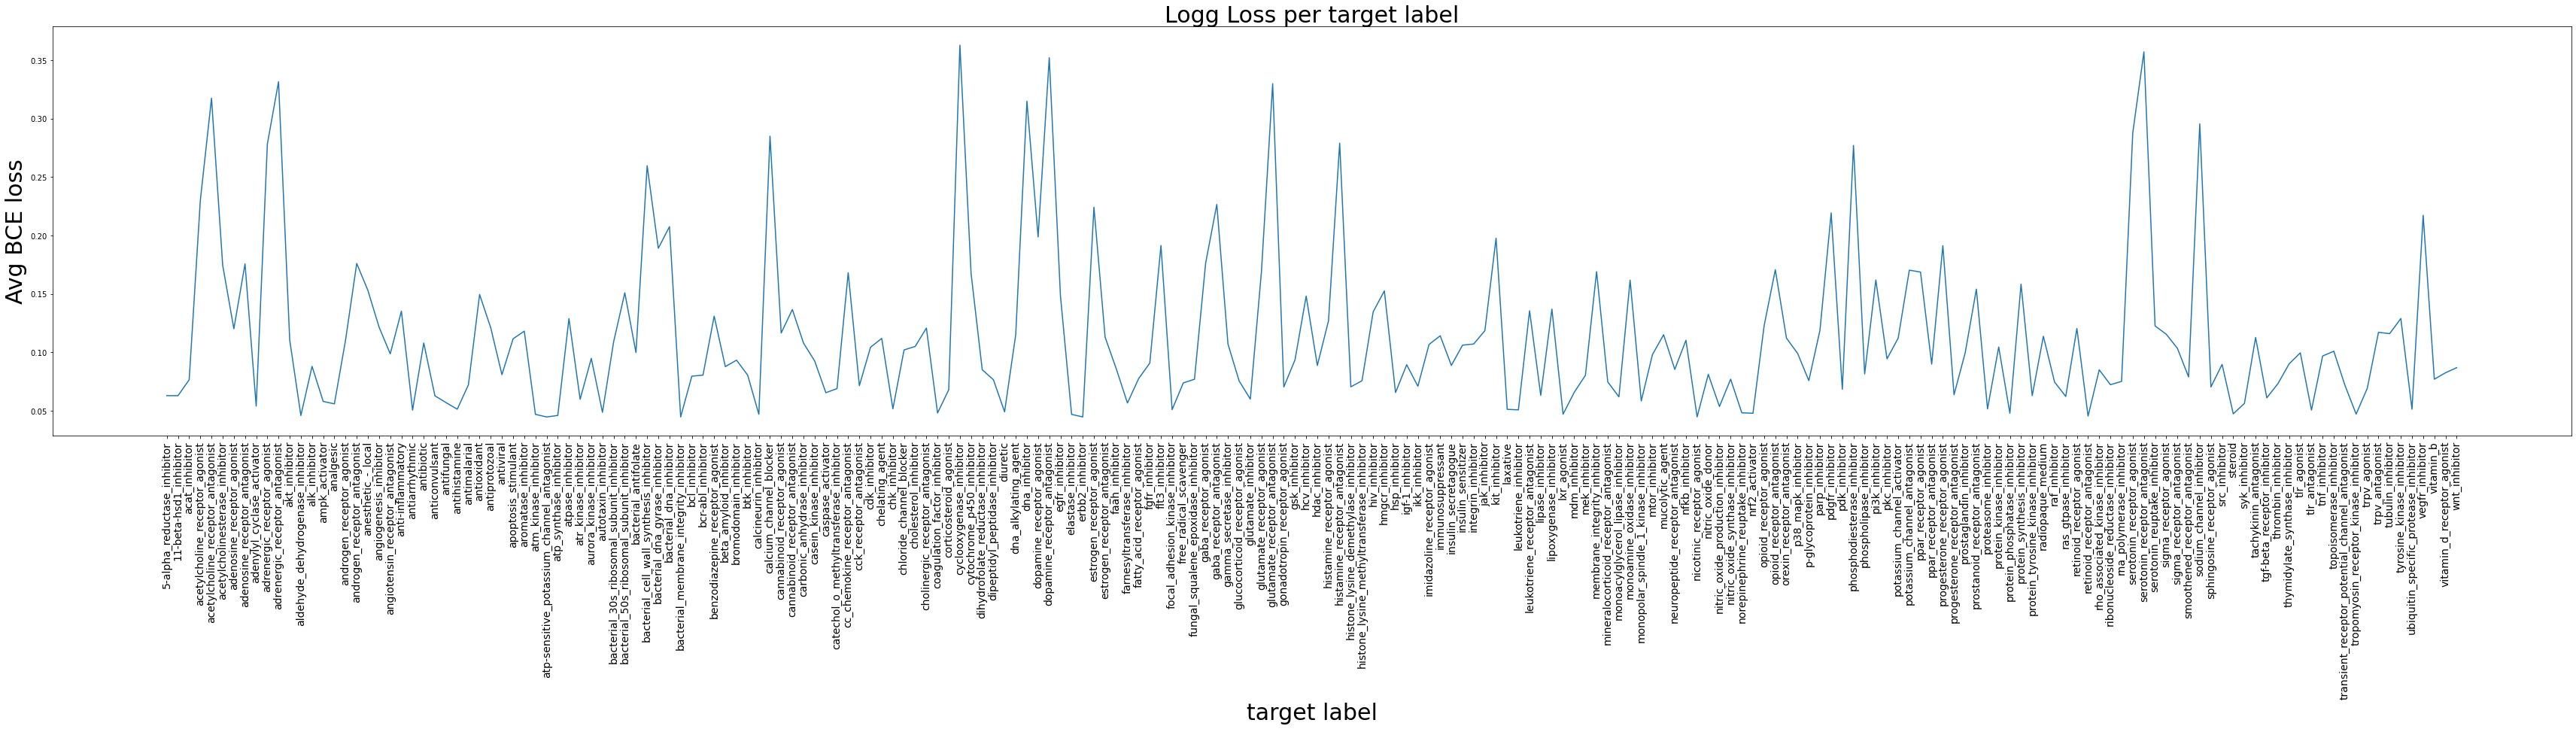

In [27]:
plt.figure(figsize = (60,10))
plt.plot(target_names, data['losses'])
plt.title('Logg Loss per target label', fontsize = 30)
plt.xlabel('target label', fontsize=30)
plt.ylabel('Avg BCE loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.show()

In [28]:
def sum1(l):
    s = 0
    for i in l:
        s+=i
    return s

In [29]:
hamming_loss = [sum1(data['losses'][:i+1])/(i+1) for i in range(len(data['losses']))]

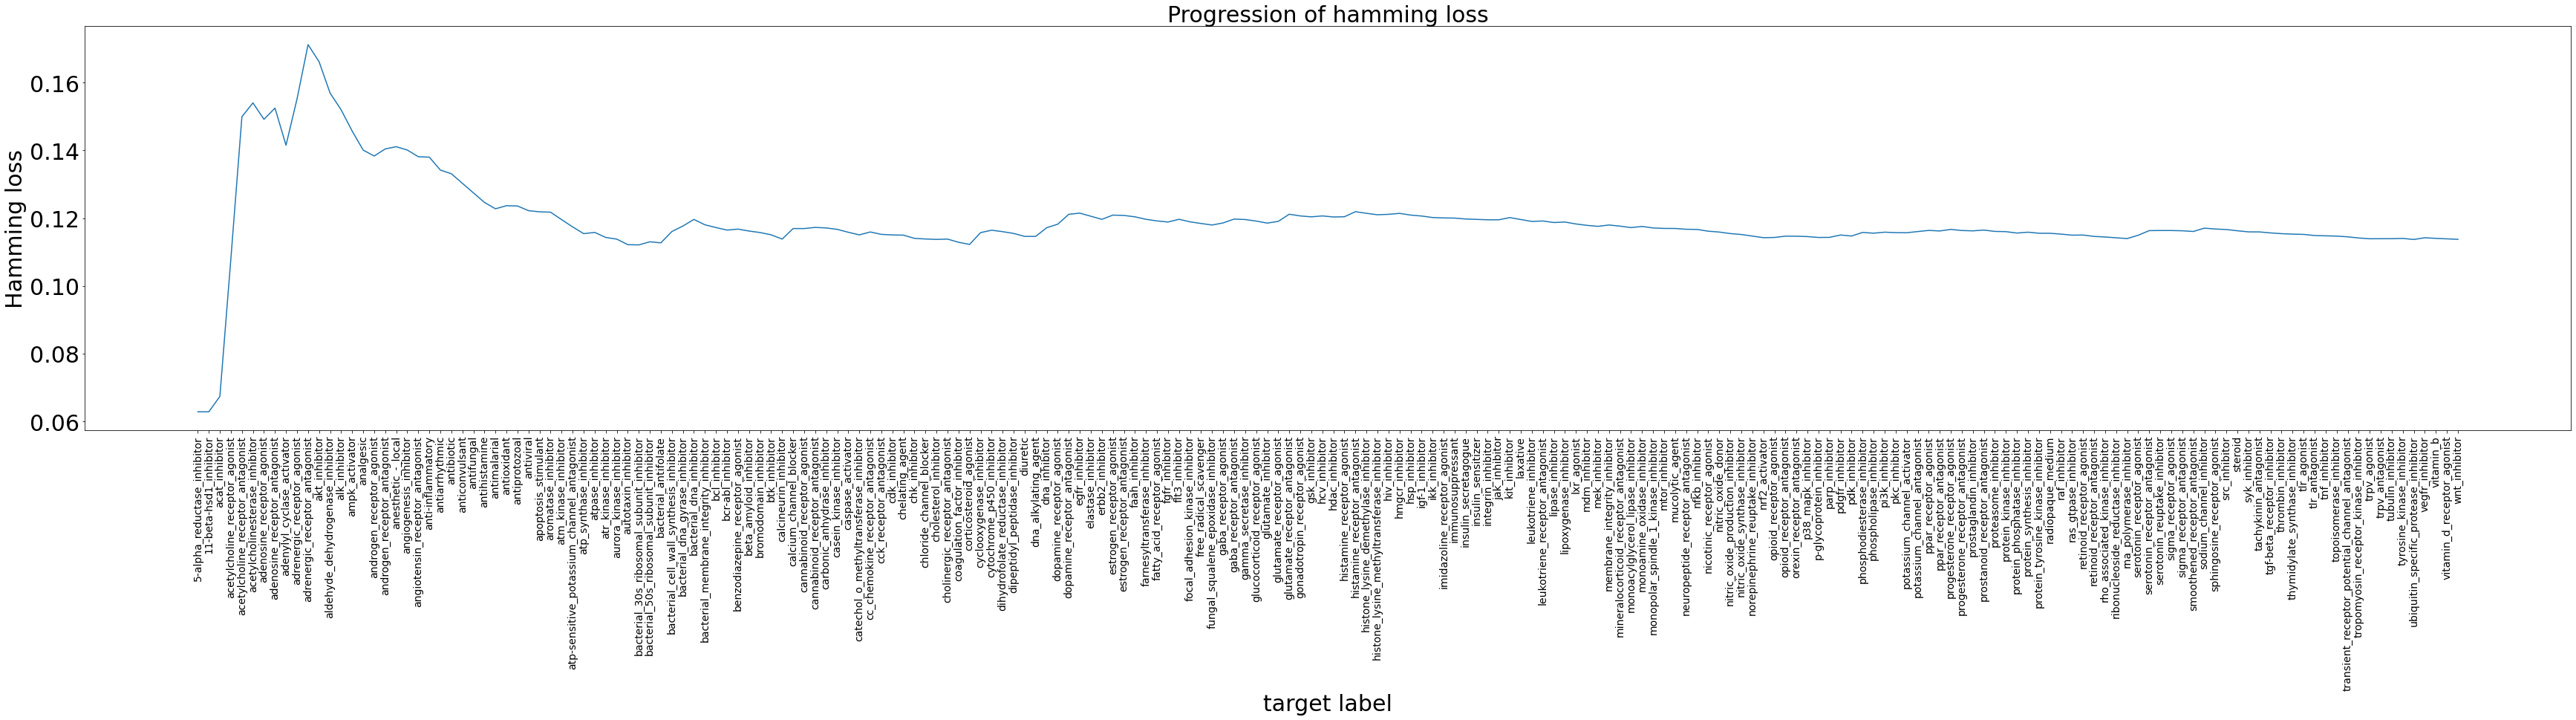

In [30]:
plt.figure(figsize = (60,10))
plt.plot(target_names, hamming_loss)
plt.title('Progression of hamming loss', fontsize = 30)
plt.xlabel('target label', fontsize=30)
plt.ylabel('Hamming loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.yticks(fontsize = 30)
plt.show()

In [31]:
# Storing some info about training dynamics

data1 = data

In [32]:
data1['train_data'] = train_data.toPandas()
data1['test_data'] = test_data.toPandas()
data1['hamming_loss'] = hamming_loss
data1['variance'] = pca_model.explainedVariance.toArray()
data1['cumulative_variance'] = cum_var
data1['correlation_matrix'] = corr_mat
data1['selected_features'] = selected_features

In [33]:
with open('data.pkl', 'wb') as f:
    pickle.dump(data1, f)
